In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#in this analysis, i used all basic classification solutions to fit the data, also tried featuretools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

df_train = pd.read_csv('../input/train.csv')


In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test = df_train['Age'].value_counts()
test = test[test>20].index
df_train[df_train.index.isin(test)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


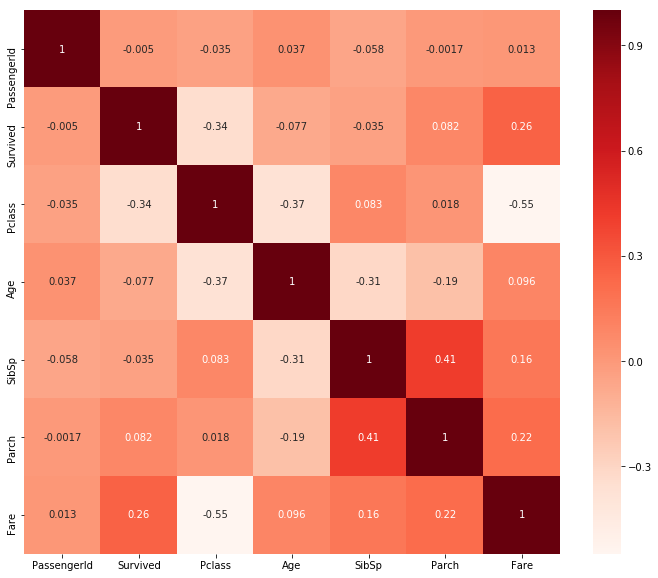

Survived    1.000000
Pclass     -0.338481
Fare        0.257307
Name: Survived, dtype: float64

In [5]:
import seaborn as sns

plt.figure(figsize=(12,10))
cor = df_train.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["Survived"])
ad = cor['Survived'][abs(cor['Survived']) > 0.25]
ad

In [6]:
numerical_features = df_train.dtypes == 'float'
print(numerical_features)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin          False
Embarked       False
dtype: bool


In [7]:
df_train_new = df_train.drop(['Cabin','Ticket','Name','PassengerId'], axis=1)
df_train_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [8]:
df_train_new.shape

(891, 8)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51ba289b38>,
      dtype=object)

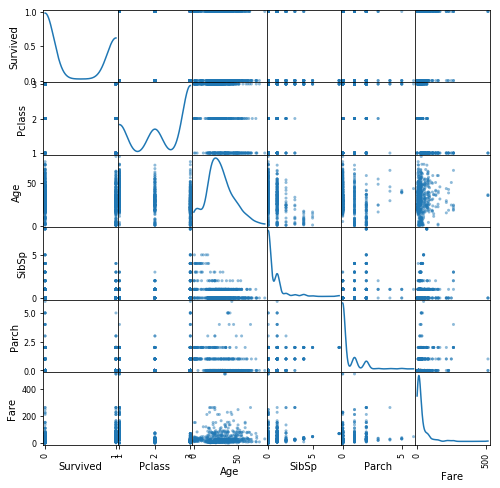

In [9]:
pd.scatter_matrix(df_train_new, figsize=(8, 8),diagonal='kde')


In [10]:
df_train_new["Age"].fillna(df_train_new["Age"].mean(), inplace=True)
df_train_new["Embarked"].fillna(df_train_new["Embarked"].value_counts().index[0], inplace=True)
df_train_new.isnull().sum()
df_train_new_2 = df_train_new[['Pclass','Sex','Age','Fare','Embarked']]
target = df_train_new['Survived']
print(type(target))

<class 'pandas.core.series.Series'>


In [11]:
preprocess = make_column_transformer((['Age', 'Fare'], StandardScaler()),(['Pclass', 'Sex', 'Embarked'], OneHotEncoder())
)
df_train_new_3 = preprocess.fit_transform(df_train_new_2)

/opt/conda/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:732: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

columns = df_train_new_3.shape[1]
score = 0
best_n = []

for n in range(1,columns+1):
    lr = LogisticRegression()
    rfe = RFE(lr,n)
    x_rfe = rfe.fit_transform(df_train_new_3,target)
    model = lr.fit(x_rfe,target)
    best_score = model.score(x_rfe,target)
    print("the score is: %f . the n is: %d" %(best_score,n))
    if best_score > score:
        score = best_score
        best_n = n
    else:
        score = score

print('final: the best score is %f, with the best n is: %d' %(best_score,best_n))

#not important feature
rfe = RFE(lr,best_n)
rfe.fit(df_train_new_3,target)
rfe.support_


the score is: 0.786756 . the n is: 1
the score is: 0.786756 . the n is: 2
the score is: 0.786756 . the n is: 3
the score is: 0.786756 . the n is: 4
the score is: 0.786756 . the n is: 5
the score is: 0.790123 . the n is: 6
the score is: 0.790123 . the n is: 7
the score is: 0.790123 . the n is: 8
the score is: 0.791246 . the n is: 9
the score is: 0.791246 . the n is: 10
final: the best score is 0.791246, with the best n is: 9


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [13]:
from sklearn.model_selection import GridSearchCV
parameter = {'C': [0.1, 1,2,4]}
lm = LogisticRegression()
Grid = GridSearchCV(lm,parameter,cv = 4)
Grid.fit(df_train_new_3,target)
Grid.best_params_
Grid.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.7912457912457912

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
rfc.fit(df_train_new_3,target)
rfc.score(df_train_new_3,target)

0.9472502805836139

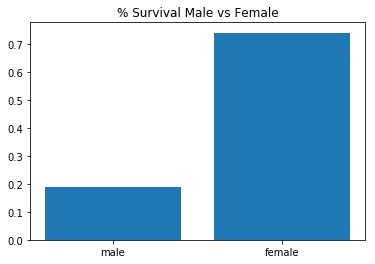

In [15]:
Male = df_train['Sex']=="male"
df_Male = df_train[Male]
y_male = df_Male.Survived.sum() / df_Male.Survived.count()

Female = df_train['Sex']=="female"
df_Female = df_train[Female]
y_female = df_Female.Survived.sum() / df_Female.Survived.count()

objects = ['male','female']
y = [y_male,y_female]
positions = range(len(objects))
plt.bar(positions,y)
plt.xticks(positions,objects)
plt.title('% Survival Male vs Female')
plt.show()

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam


# initialize the network
model = Sequential()

# add nodes to the network
model.add(Dense(5,input_shape = (10,), activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='relu'))
model.compile(Adam(lr=.01),'binary_crossentropy', metrics=['accuracy'])
model.fit(df_train_new_3, target, epochs=200, verbose=1)
eval_result = model.evaluate(df_train_new_3, target)
print("\n\nTest loss:", eval_result[0], "Test accuracy:", eval_result[1])





Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
891/891 [==============================] - 1s 648us/step - loss: 1.3245 - acc: 0.6352
Epoch 2/200
891/891 [==============================] - 0s 36us/step - loss: 0.6771 - acc: 0.7508
Epoch 3/200
891/891 [==============================] - 0s 36us/step - loss: 0.6268 - acc: 0.7710
Epoch 4/200
891/891 [==============================] - 0s 36us/step - loss: 0.5362 - acc: 0.7710
Epoch 5/200
891/891 [==============================] - 0s 36us/step - loss: 0.5503 - acc: 0.7722
Epoch 6/200
891/891 [==============================] - 0s 36us/step - loss: 0.5669 - acc: 0.7385
Epoch 7/200
891/891 [==============================] - 0s 36us/step - loss: 0.5822 - acc: 0.6880
Epoch 8/200
891/891 [==============================] - 0s 35us/step - loss: 0.5429 - 

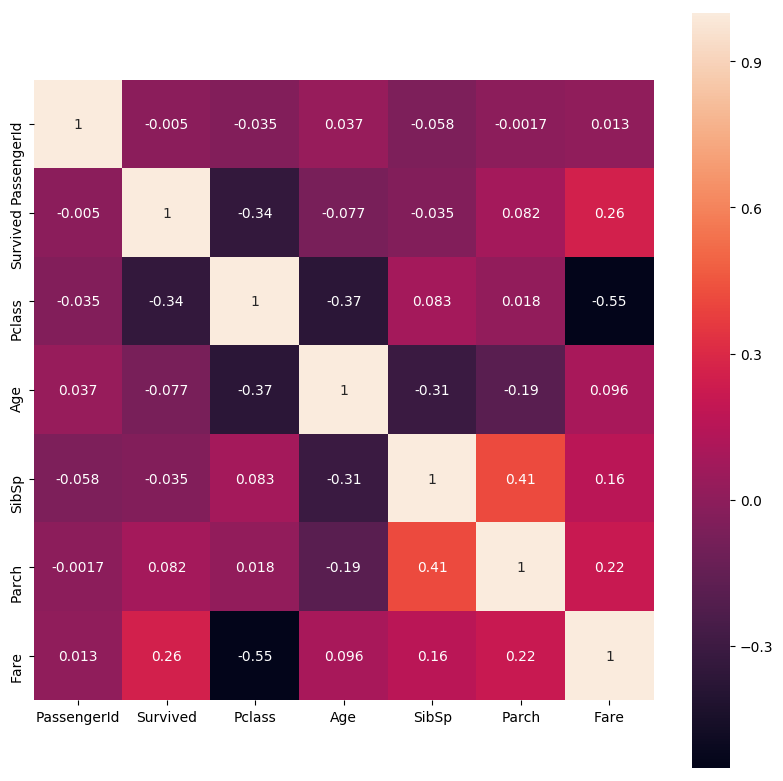

In [17]:
plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(df_train.corr(), square=True, annot=True)

In [18]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear')
model.fit(df_train_new_3,target)
model.score(df_train_new_3,target)

0.7867564534231201

In [19]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(df_train_new_3,target)
clf.score(df_train_new_3,target)

0.7800224466891134

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


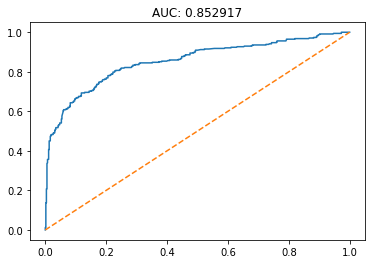

(array([0.82123894, 0.7392638 ]),
 array([0.84517304, 0.70467836]),
 array([0.83303411, 0.72155689]),
 array([549, 342]))

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
model = LogisticRegression()
model.fit(df_train_new_3,target)
predictions = model.predict_proba(df_train_new_3)
predictions1 = model.predict(df_train_new_3)
predictions = predictions[:, 1]
fpr, tpr, thresholds = roc_curve(target, predictions)
auc = roc_auc_score(target, predictions)
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('AUC: %f' %auc)
plt.show()

precision_recall_fscore_support(target, predictions1)


In [21]:
x = pd.DataFrame(df_train_new_3, columns=['a', 'b', 'c', 'd', 'e','f','g','h','i','j'])
x = x.reset_index()
x.head()

import featuretools as ft
#creating and entity set 'es'
es = ft.EntitySet(id = 'target')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'Titanic', dataframe = x , index = 'index')
es.normalize_entity(base_entity_id='Titanic', new_entity_id='second', index = 'index', 
additional_variables = ['h', 'i', 'j'])

print(es)

# Create new features using specified primitives
feature_matrix, feature_names = ft.dfs(entityset=es, 
target_entity = 'Titanic', 
max_depth = 2, 
verbose = 1, 
n_jobs = 3)
feature_matrix.columns
feature_matrix.dropna(axis = 1, inplace = True)

model = LogisticRegression()
model.fit(feature_matrix,target)
score = model.score(feature_matrix,target)
print(score)

Entityset: target
  Entities:
    Titanic [Rows: 891, Columns: 8]
    second [Rows: 891, Columns: 4]
  Relationships:
    Titanic.index -> second.index
Built 52 features
EntitySet scattered to workers in 0.491 seconds
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
0.7901234567901234


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
